In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
df = pd.read_csv('./Processed_Data/data.csv', index_col=0)

### The dataset needs to be cleaned for deviations in how Location was reported.
This is largely based upon spacing irregularities and punctiation differences. Running a few str modules through a lamda apply function should help clean this up. Strip() will remove leading and trailing white spaces while Split() will allow me to extract the City as the first item listed in the Location.

In [3]:
df.sample(10)

,Company,Location,Job_Title,Subspecialty,Total_Comp,Role
23290,Goldman Sachs,"Jersey City, N",Executive Director / Vice-President,Distributed Systems (Back-End),"$210,000",Software Engineer
3409,amazon,Seattle,PM ll,retail,"$185,000",Product Manager
20655,HPE,San Jose,L4,Filesystem/Storage,"$241,000",Software Engineer
4346,Amazon,Seattle,L5,Robotics,"$164,000",Product Manager
18384,Microsoft,Bellevue,59,DevOps,"$161,000",Software Engineer
8780,Qualcomm,San Diego,Senior,Testing (SDET),"$194,000",Software Engineer
18899,Apple,Cupertino,ICT3,ML / AI,"$209,000",Software Engineer
7798,Microsoft,Redmond,59,Full Stack,"$165,000",Software Engineer
9480,Oracle,"Redwood City, CA",IC-3,DevOps,"$150,000",Software Engineer
12629,Facebook,Menlo Park,E5,API Development (Back-End),"$343,000",Software Engineer


In [4]:
df['Location'] = df['Location'].apply(lambda x: x.strip().split(',')[0])

In [5]:
df['Location'].value_counts()[:20]

Seattle          4839
San Francisco    3735
New York         2021
Redmond          1682
Mountain View    1296
Sunnyvale        1275
San Jose         1001
Menlo Park        848
Cupertino         711
Palo Alto         655
Austin            546
Boston            524
Bellevue          474
Santa Clara       462
San Diego         401
London            371
Bangalore         353
Los Angeles       289
Chicago           288
Vancouver         246
Name: Location, dtype: int64

### Check for perpetuating Nulls

The null values should have been dropped from a previous data cleaning notebook, but let's verify

In [6]:
df.isna().sum()

Company         0
Location        0
Job_Title       0
Subspecialty    0
Total_Comp      0
Role            0
dtype: int64

In [7]:
df.head()

,Company,Location,Job_Title,Subspecialty,Total_Comp,Role
0,McKinsey,San Francisco,Senior,Analytic,"$198,000",Consultant
1,Facebook,Menlo Park,L4,Product,"$177,000",Consultant
2,Accenture,San Francisco,Consultant,Analytic,"$120,000",Consultant
3,Salesforce,Atlanta,8,Operations,"$178,000",Consultant
4,Oracle,San Francisco,IC-4,Consumer,"$82,000",Consultant


### We need to convert the salaries to a float for regression.

In [8]:
df['Total_Comp'] = df['Total_Comp'].str.replace(',', '').str.replace('$', '').astype(float)
df.head()

,Company,Location,Job_Title,Subspecialty,Total_Comp,Role
0,McKinsey,San Francisco,Senior,Analytic,198000.0,Consultant
1,Facebook,Menlo Park,L4,Product,177000.0,Consultant
2,Accenture,San Francisco,Consultant,Analytic,120000.0,Consultant
3,Salesforce,Atlanta,8,Operations,178000.0,Consultant
4,Oracle,San Francisco,IC-4,Consumer,82000.0,Consultant


### Preliminary Data Exploration

Let's take a look at our most common companies, locations, job titles, subspecialties, and roles.
Then let's also explore the range of saleries reported.

In [9]:
df.describe(include='O')

,Company,Location,Job_Title,Subspecialty,Role
count,29056,29056,29056,29056,29056
unique,751,573,1370,1141,8
top,Amazon,Seattle,Senior,Distributed Systems (Back-End),Software Engineer
freq,4157,4839,2847,6143,21813


In [10]:
df.describe()

,Total_Comp
count,2.905600e+04
mean,2.316990e+05
std,1.507435e+05
min,1.000000e+04
25%,1.500000e+05
50%,2.000000e+05
75%,2.780000e+05
max,5.000000e+06


We now now that the modes of our features and mean of our target:
- Company - Amazon
- Location - Seattle
- Job Title - Senior
- Subspeciatly - Distributed Systems (Back-End)
- Role - Software Engineering

And Total Comp - $231,699

### Outlier Considerations

If we look closely at our cursory descriptive statistics for our total compensation, we will notice that the maximum reported salary is 5,000,000 and there is a standard deviation of 150,743. Let's visualize this spread.

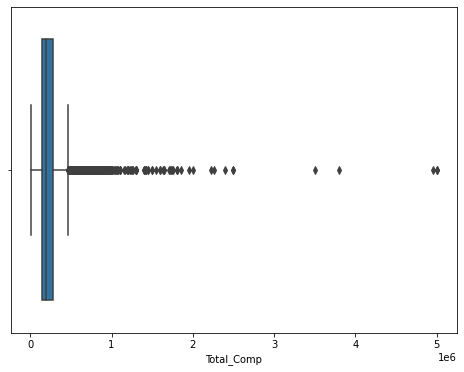

In [11]:
plt.figure(figsize=(8,6))
sns.boxplot(df['Total_Comp'])
plt.show()

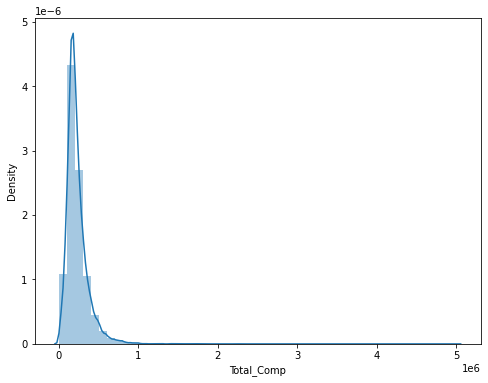

In [12]:
plt.figure(figsize=(8,6))
sns.distplot(df['Total_Comp'])
plt.show()

### Let's use the Z scores to filter out some of the outliers. 

The Z score is the number of standard deviations of an observed data point from the mean. We will set a filter for 2 std. We must account for the absolute value of the Z score, since the value could also fall 2 std less than the mean.


In [13]:
z= np.abs(stats.zscore(df['Total_Comp']))
df_filtered = df[z<2].reset_index(drop=True)

So how many rows were removed due to being outliers?

In [14]:
df.shape, df_filtered.shape

((29056, 6), (28092, 6))

Almost 1,000 rows!

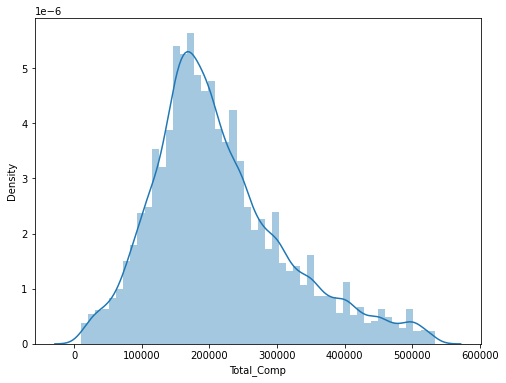

In [15]:
plt.figure(figsize=(8,6))
sns.distplot(df_filtered['Total_Comp'])
plt.show()

<AxesSubplot:xlabel='Total_Comp'>

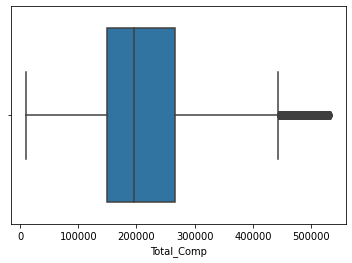

In [16]:
sns.boxplot(df_filtered['Total_Comp'])

In [17]:
df_filtered.describe()

,Total_Comp
count,28092.000000
mean,214325.288338
std,99252.225260
min,10000.000000
25%,149000.000000
50%,196000.000000
75%,267000.000000
max,533000.000000


### Now that we have cleaned some of the data, let's see which cities have the highest average total compensation.

In [18]:
def grouped_plots(df, feature):
    plots = df.groupby(feature)['Total_Comp'].mean().sort_values(ascending = False)[:30]
    plt.figure(figsize=(10,8))
    plt.bar(plots.index, plots)
    plt.ylabel('Total Compensation ($)')
    plt.xlabel(feature)
    plt.title(f'Total Compensation grouped by {feature}')
    plt.xticks(rotation = 90)
    plt.show()

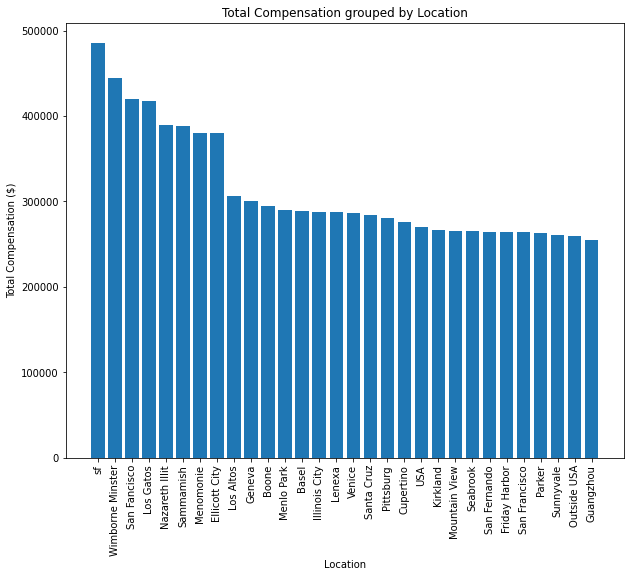

In [19]:
grouped_plots(df_filtered, 'Location')

### We can now see that there is an issue with "one off" reportings largely skewing the reports for various cities.

To correct this we will need to set a frequency threshold based on the value counts of cities. Otherwise, a user querying their expected salary will be unusually impacted by these "one off" reports. We will set a 0.5% threshold and anything less than this number of reportings will be categorized into a Location of "Other"

In [20]:
def threshold_filter(df, feature, filter = 0.005):
    df = df.copy()
    values = df[feature].value_counts()
    threshold = filter * values.sum()

    df[feature] = df[feature].apply(lambda x: x if values[x] > threshold else "Other")
    return df

In [21]:
df_filtered_location = threshold_filter(df_filtered, 'Location')

In [22]:
len(df_filtered['Location'].value_counts())

573

In [23]:
len(df_filtered_location['Location'].value_counts())

27

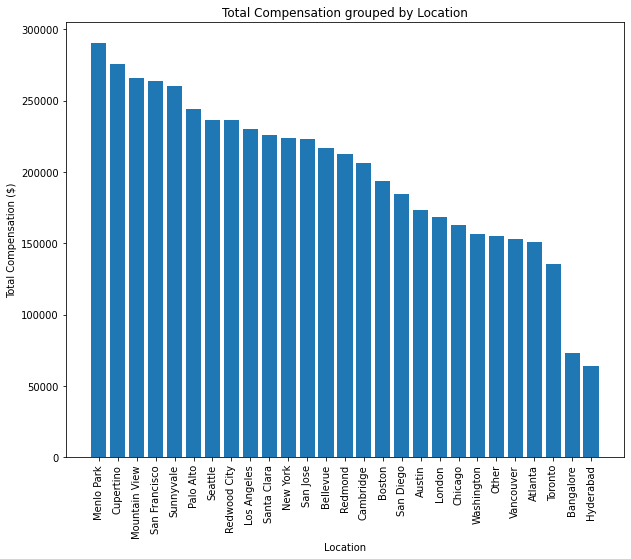

In [24]:
grouped_plots(df_filtered_location, 'Location')

### We can now see a much cleaner grouping of Total Compensation based upon frequently occuring Locations.

Not only did we remove these "one off" locations by binning them into an "Other" value, but we also managed to reduce our range of values for the Location feature to 27. This is a huge improvement over the previous value of 573.

Further, we can start to see that there may be a distinction in Total Compensation based upon Location. We will save this concept for our later modeling.

### Let's take a look at the values for the other categorical columns and apply the same threshold transformation.

In [25]:
len(df_filtered['Job_Title'].value_counts())

1345

In [28]:
df_filtered_jobs = threshold_filter(df_filtered, 'Job_Title')

In [29]:
len(df_filtered_jobs['Job_Title'].value_counts())

35

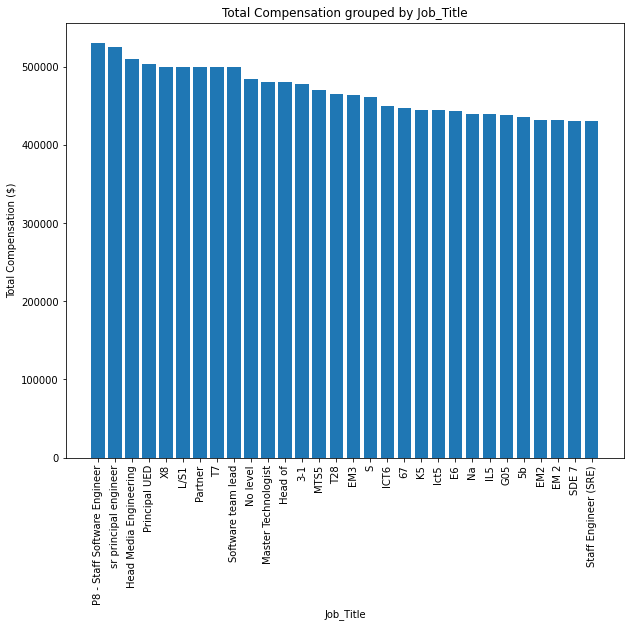

In [30]:
grouped_plots(df_filtered, 'Job_Title')

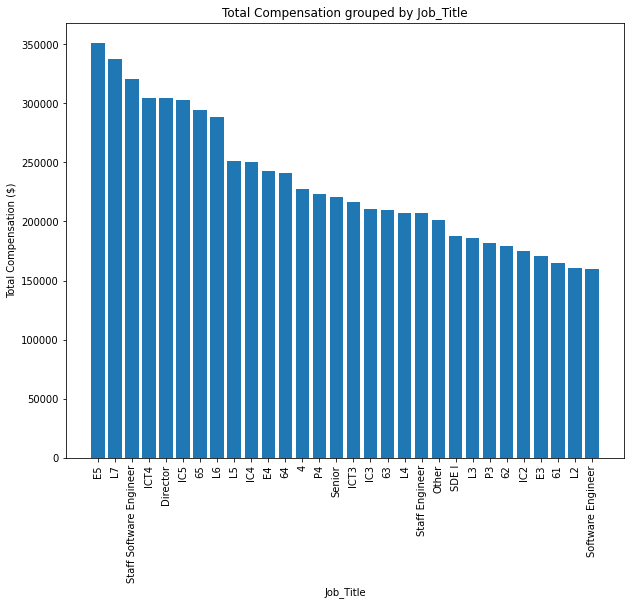

In [31]:
grouped_plots(df_filtered_jobs, 'Job_Title')

In [32]:
len(df_filtered['Subspecialty'].value_counts())

1114

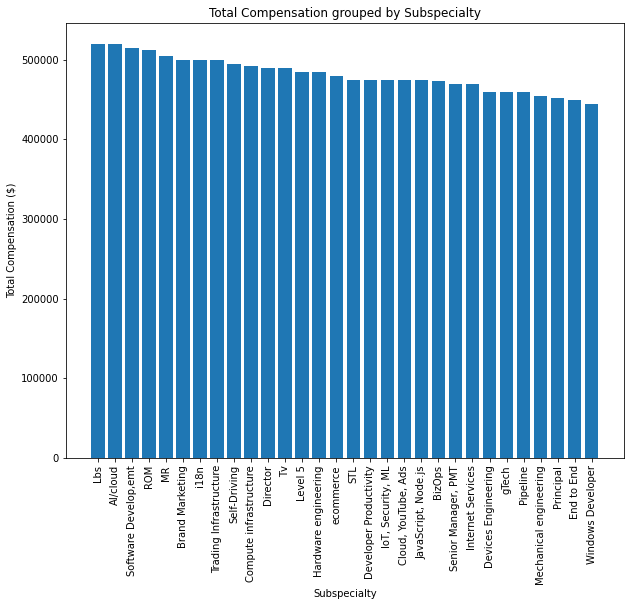

In [33]:
grouped_plots(df_filtered, 'Subspecialty')

In [34]:
df_filtered_subspecialty = threshold_filter(df_filtered,'Subspecialty')

In [35]:
len(df_filtered_subspecialty['Subspecialty'].value_counts())

17

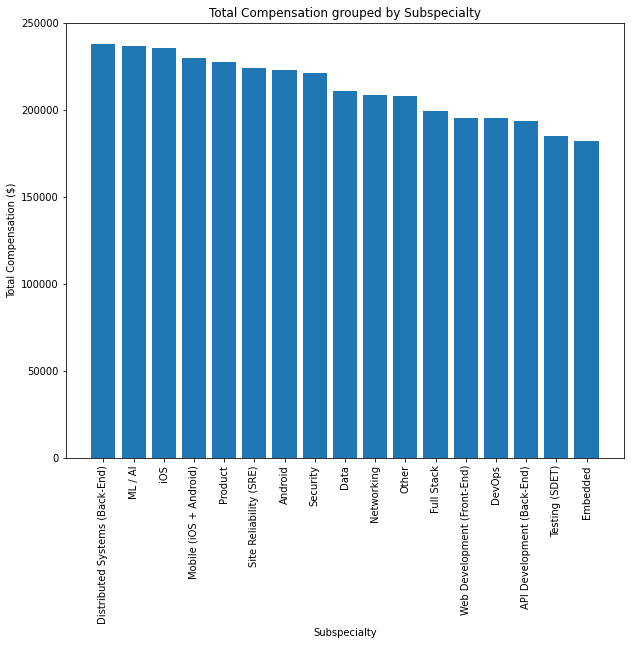

In [36]:
grouped_plots(df_filtered_subspecialty,'Subspecialty')

In [37]:
len(df_filtered['Company'].value_counts())

751

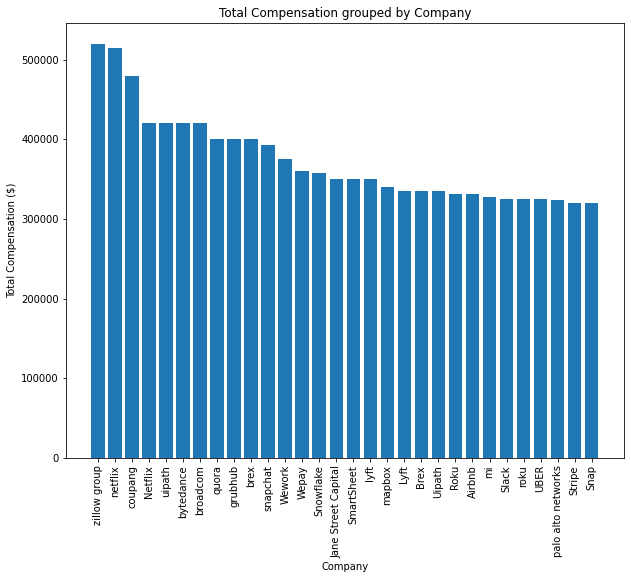

In [38]:
grouped_plots(df_filtered,'Company')

### A new data preparation problem has been unveiled from the above bar graph.

There are two occurances of "Lyft" on the graph. Similarly, the very first column is "zillow group" which makes me wonder if "Zillow" or "zillow" also appear in the dataframe.

In [39]:
sum(df_filtered['Company'] == 'Zillow'), sum(df_filtered['Company'] == 'zillow'), sum(df_filtered['Company'] == 'zillow group')

(104, 2, 1)

There aren't a large number of different company spellings (for Zillow), but they should be cleaned to the greatest extent possible to retain their use for our future modeling.

In [42]:
df_filtered[df_filtered['Company'] =='uber']

,Company,Location,Job_Title,Subspecialty,Total_Comp,Role
149,uber,New York,l4,none,200000.0,Consultant
262,uber,Seoul,L6,Networking,200000.0,Consultant
3754,uber,San Francisco,pm 2,ML / AI,240000.0,Product Manager
10431,uber,Palo Alto,l4,Distributed Systems (Back-End),270000.0,Software Engineer
11685,uber,San Francisco,L4,Distributed Systems (Back-End),270000.0,Software Engineer
16060,uber,San Francisco,Engineer 2,API Development (Back-End),200000.0,Software Engineer
16794,uber,San Francisco,Software Engineer,iOS,155000.0,Software Engineer
21337,uber,Seattle,5b,Distributed Systems (Back-End),260000.0,Software Engineer
25252,uber,San Francisco,Senior,Web Development (Front-End),501000.0,Software Engineer
25253,uber,San Francisco,Senior,Web Development (Front-End),501000.0,Software Engineer


In [43]:
df_filtered.loc[149]['Company'].title()

'Uber'

Let's start by applying a lambda function to convert all of the Company names to the str format of Title, which will capitalize the first letter of each distinct word in the Company name.

In [44]:
df_filtered['Company'] = df_filtered['Company'].apply(lambda x: x.title())
len(df_filtered['Company'].value_counts())

487

We have reduced our feature set by around 300 just by applying the string title transformation. Now we will apply our threshold function to further clean the dataset. 

In [45]:
df_filtered_company = threshold_filter(df_filtered, 'Company')

In [46]:
len(df_filtered_company['Company'].value_counts())

33

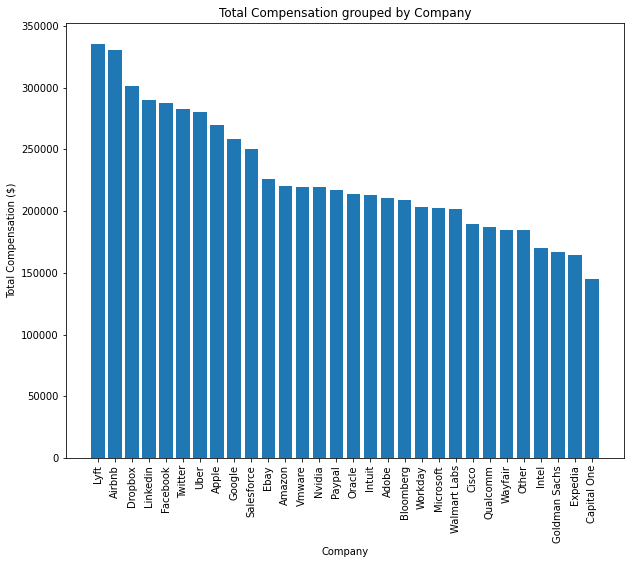

In [47]:
grouped_plots(df_filtered_company, 'Company')

### Down to our last feature: Role

In [48]:
df_filtered['Role'].value_counts()

Software Engineer            21304
Product Manager               2309
Software Manager              1667
Data Scientist                1179
Product Designer               681
Technical Program Manager      425
Consultant                     271
Marketing                      256
Name: Role, dtype: int64

This looks good, so we will now combine all of our filters and outlier extraction to form a final dataframe.

In [49]:
df_final = df_filtered.copy()
df_final['Company'] = df_filtered_company['Company']
df_final['Location'] = df_filtered_location['Location']
df_final['Job_Title'] = df_filtered_jobs['Job_Title']
df_final['Subspecialty'] = df_filtered_subspecialty['Subspecialty']


In [50]:
df_final

,Company,Location,Job_Title,Subspecialty,Total_Comp,Role
0,Other,San Francisco,Senior,Other,198000.0,Consultant
1,Facebook,Menlo Park,L4,Product,177000.0,Consultant
2,Other,San Francisco,Other,Other,120000.0,Consultant
3,Salesforce,Atlanta,Other,Other,178000.0,Consultant
4,Oracle,San Francisco,Other,Other,82000.0,Consultant
...,...,...,...,...,...,...
28087,Microsoft,Redmond,62,Other,174000.0,Technical Program Manager
28088,Paypal,San Jose,Other,Other,335000.0,Technical Program Manager
28089,Amazon,Seattle,L5,Security,180000.0,Technical Program Manager
28090,Amazon,Sunnyvale,L6,Full Stack,254000.0,Technical Program Manager


In [51]:
df_final.to_csv('./Processed_Data/data.csv')